In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})

In [86]:
data = pd.read_csv('../../data/train/dates.csv', parse_dates=['full_date'])

In [87]:
np.max(data['full_date']) - np.min(data['full_date'])

Timedelta('761 days 00:00:00')

In [88]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,total_of_special_requests,reservation_status,reservation_status_date,total_nights,party_size,is_family,room_difference,had_agent,had_company,full_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,0,2.0,0,0,1,1,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,Check-Out,2015-07-01,0,2.0,0,0,1,1,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1,1.0,0,1,1,1,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,Check-Out,2015-07-02,1,1.0,0,0,0,0,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,1,Check-Out,2015-07-03,2,2.0,0,0,0,0,2015-07-01


In [89]:
start_day = (data['full_date'] - np.min(data['full_date'])).dt.days
bookings_by_day = np.zeros(762)

In [90]:
for day, nights in zip(start_day, data['total_nights']):
    bookings_by_day[day:(day + nights + 1)] += 1

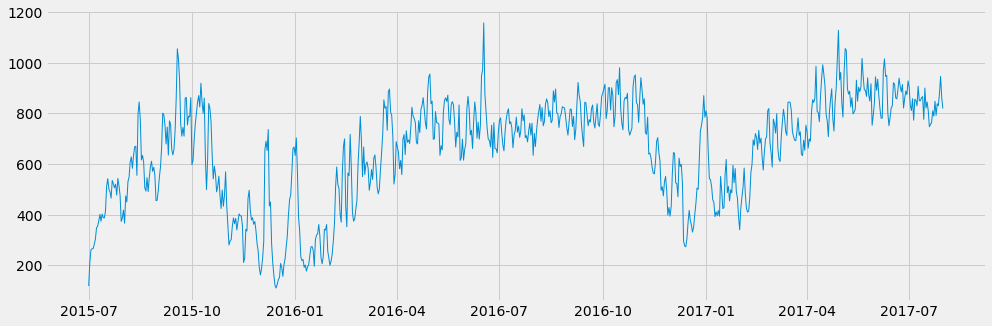

In [91]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(sorted(data['full_date'].unique()), bookings_by_day, linewidth=1)